# Finite difference solver for T and C

Our particle growth calculations can yield solid growth rates
along the trajectory and we can relate this to the production of
heat and oxygen from crystal growth as a function of height above
the ICB. Here we seek to treat these as source terms in a finite
difference solution for the relaxed temperature (and oxygen content)
with defined boundary conditions at the top and bottom of the F-layer.
The idea is that we can then proceed as follows:

1. Pick an initial $T(R)$ and $C(R)$.
2. Solve the IVP for all the falling particles.
3. Calculate the heat and oxygen production rates, 
$Q(R)$ and $J(R)$.
4. Find $T(R)$ and $C(R)$ consistent with these source 
terms and the boundary conditions
5. Put these new functions into 2 and iterate.
6. When converged we have a solution that gives the fluxes out of the 
layer and everything we already calculate which includes latent heat
(which may push us towards equilibrium.

We end up with two iterative solutions (inside 4, and the 2 - 5 loop).
My guess is that 4 is fast compared to 2 - 5, which is why we converge
this at each step rather than take a single FD iteration inside the
outer loop.

This notebook outlines the development of the FD diffusion solver
in a way that is decoupled from the rest of the code. Note that the
same solver can be used for the two systems (just exchanging chemical 
and thermal diffusivity and choosing different boundary conditions and
source terms) and these can be treated separately unless we want to 
couple e.g. thermal conduction and oxygen content of the melt (which
seems excessive).

In [2]:
# Imports and system setup
import numpy as np
import numba

r_icb = 1221.5e3
f_layer_thickness = 200.0e3



$$\frac{1}{R^2}\frac{\mathrm{d}}{\mathrm{d} R}\left(\kappa R^2 \frac{\mathrm{d} T(R)}{\mathrm{d} R} \right) = Q(R) $$

or

$$\kappa R^2 \frac{\mathrm{d}^2 T}{\mathrm{d} R^2} + 2 \kappa R \frac{\mathrm{d} T}{\mathrm{d} R} - R^2 Q(R) = 0$$

We need to write this second order ODE as a system of two first order equations. Sub $y_1 = T$ and $y_2 = \frac{\mathrm{d} T}{\mathrm{d} R}$;
$y_1^{\prime} = y_2$ and $y_2^{\prime} = \frac{\mathrm{d}^2 T}{\mathrm{d} R^2}$ then:

$$\kappa R^2 y_2^{\prime} + 2 \kappa R y_1^{\prime} - R^2 Q(R) = 0$$

so


$$y_1^{\prime} = \frac{(R^2 Q(R) - \kappa R^2 y_2^{\prime})}{ 2 \kappa R}$$

$$y_2^{\prime} = \frac{(R^2 Q(R) - 2 \kappa R y_2)}{\kappa R^2}$$

And assuming I have this right, we can stuff this into a BVP solver
binding $Q(R)$ to our points.

In [3]:
r = np.linspace(r_icb, r_icb+f_layer_thickness)
# call everything 10
heat_sources = np.ones_like(r) * 10.0
heat_sources[0] = 0.0
heat_sources[-1] = 0.0
kappa = 5.0
initial_t = np.ones_like(r) * 100.0

In [ ]:
def fun(x, y):
    

In [4]:
def fun(x, y):
    return np.vstack((y[1], -np.exp(y[0])))

In [17]:
def bc(ya, yb):
    return np.array([ya[0], yb[0]])

In [18]:
x = np.linspace(0, 1, 5)

In [19]:
y_a = np.zeros((2, x.size))
y_b = np.zeros((2, x.size))
y_b[0] = 3


In [20]:
from scipy.integrate import solve_bvp
res_a = solve_bvp(fun, bc, x, y_a)
res_b = solve_bvp(fun, bc, x, y_b)

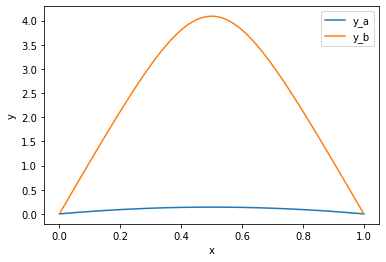

In [21]:
x_plot = np.linspace(0, 1, 100)
y_plot_a = res_a.sol(x_plot)[0]
y_plot_b = res_b.sol(x_plot)[0]
import matplotlib.pyplot as plt
plt.plot(x_plot, y_plot_a, label='y_a')
plt.plot(x_plot, y_plot_b, label='y_b')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()